In [1]:
import pandas as pd
import pickle
import numpy as np
from numpy import sort

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils import shuffle, resample

import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
import os

import warnings
warnings.filterwarnings('ignore')

# Create Recurring model by training existing recurring user

In [2]:
%%bigquery df
SELECT
    MOBILE
    ,TARGET_MONTH
    ,TPV_6M
    ,TS
    ,COVER_DAY_6M
    ,PT_FIX_SPEED_UL_COVER_6M
    ,TOTAL_MONTH
    ,SOF_OTHER_FREQ_6M
    ,PT_FIX_SPEED_NS_COVER_6M
    ,V_CODE_6M
    ,RC_FLAG
    ,RC_RECENCY
    ,SIM_MONTH_AGE
FROM `acm-bi.Analysis.SA_VAS_RECURRING_202006_202103_FACT`
WHERE RC_RECENCY <> -1
AND TARGET_MONTH = '2020-12-01'

In [3]:
def load_data(df,balance=False):
#     df = pd.read_csv(os.path.join(DATA_PATH, filename))
    df = shuffle(df)
    
    if balance == True:
        df_majority = df[df['RC_FLAG'] == 0]
        df_minority = df[df['RC_FLAG'] == 1]
        
        df_majority_downsampled = resample(df_majority,replace=False,n_samples=len(df_minority),random_state=123)

        df = pd.concat([df_majority_downsampled, df_minority])
    X = df.drop([
        'RC_FLAG'
        ,'TARGET_MONTH'
        ,'MOBILE'
        ,'RC_RECENCY'
    ],axis=1)
    
    y = df[['RC_FLAG']]
    mobile = df[['MOBILE']]
    return X, y, mobile

In [4]:
X,y,mobile = load_data(df)
y['RC_FLAG'].value_counts()

0    3868741
1    1714210
Name: RC_FLAG, dtype: int64

# Train model

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=42)

In [6]:
model = xgb.XGBClassifier(importance_type='weight')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
pred_prob = model.predict_proba(X_test)

acc = accuracy_score(y_test, predictions)
f1_acc = f1_score(y_test, predictions)

print('ACCURACY :', acc)
print('F1 SCORE :', f1_acc)

[02:51:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ACCURACY : 0.8682015169386105
F1 SCORE : 0.772615252925262


# Save model

In [7]:
model.save_model('model_result/recurring.json')

# Evaluate

## Existing

In [8]:
%%bigquery df_jan
SELECT
    MOBILE
    ,TARGET_MONTH
    ,TPV_6M
    ,TS
    ,COVER_DAY_6M
    ,PT_FIX_SPEED_UL_COVER_6M
    ,TOTAL_MONTH
    ,SOF_OTHER_FREQ_6M
    ,PT_FIX_SPEED_NS_COVER_6M
    ,V_CODE_6M
    ,RC_FLAG
    ,RC_RECENCY
    ,SIM_MONTH_AGE
FROM `acm-bi.Analysis.SA_VAS_RECURRING_202006_202103_FACT`
WHERE RC_RECENCY <> -1
AND TARGET_MONTH = '2021-01-01'

In [9]:
# model = xgb.Booster({'nthread': 4})
# model.load_model('model_result/recurring.json')
X,y,mobile = load_data(df_jan)

y_pred = model.predict(X)
predictions = [round(value) for value in y_pred]
pred_prob = model.predict_proba(X_test)

acc = accuracy_score(y, predictions)
f1_acc = f1_score(y, predictions)

print('ACCURACY :', acc)
print('F1 SCORE :', f1_acc)

ACCURACY : 0.8408722926538004
F1 SCORE : 0.7504358926015313


In [10]:
table_schema=[
    {'name': 'MOBILE', 'type': 'STRING'},
    {'name': 'TARGET_MONTH', 'type': 'DATE'},
    {'name': 'TPV_6M', 'type': 'FLOAT'},
    {'name': 'TS', 'type': 'FLOAT'},
    {'name': 'COVER_DAY_6M', 'type': 'FLOAT'},
    {'name': 'PT_FIX_SPEED_UL_COVER_6M', 'type': 'INTEGER'},
    {'name': 'TOTAL_MONTH', 'type': 'INTEGER'},
    {'name': 'SOF_OTHER_FREQ_6M', 'type': 'INTEGER'},
    {'name': 'PT_FIX_SPEED_NS_COVER_6M', 'type': 'INTEGER'},
    {'name': 'V_CODE_6M', 'type': 'INTEGER'},
    {'name': 'RC_FLAG', 'type': 'INTEGER'},
    {'name': 'RC_RECENCY', 'type': 'INTEGER'},
    {'name': 'SIM_MONTH_AGE', 'type': 'INTEGER'},
    {'name': 'PROB', 'type': 'FLOAT'}
]

In [11]:
jan_prob_result = model.predict_proba(df_jan.drop(['MOBILE','TARGET_MONTH','RC_FLAG','RC_RECENCY'],axis=1))
df_jan['PROB'] = jan_prob_result[:,1:]

In [12]:
df_jan.shape

(5506684, 14)

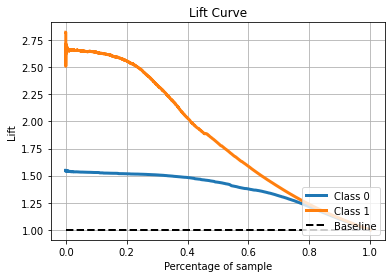

In [13]:
skplt.metrics.plot_lift_curve(df_jan[['RC_FLAG']], jan_prob_result)
plt.show()

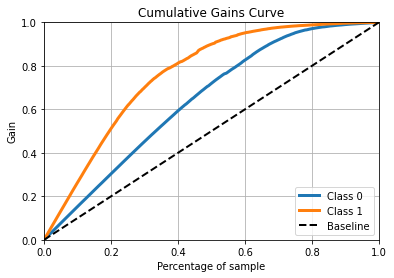

In [14]:
skplt.metrics.plot_cumulative_gain(df_jan[['RC_FLAG']], jan_prob_result)
plt.show()

In [33]:
df_jan.to_gbq(
    destination_table='Analysis.SA_VAS_RECURRING_EXISTING_JAN21_RESULT',
    project_id='acm-bi',
    if_exists='replace',
    table_schema=table_schema
)

In [34]:
df_jan.columns

Index(['MOBILE', 'TARGET_MONTH', 'TPV_6M', 'TS', 'COVER_DAY_6M',
       'PT_FIX_SPEED_UL_COVER_6M', 'TOTAL_MONTH', 'SOF_OTHER_FREQ_6M',
       'PT_FIX_SPEED_NS_COVER_6M', 'V_CODE_6M', 'RC_FLAG', 'RC_RECENCY',
       'SIM_MONTH_AGE', 'PROB'],
      dtype='object')

## New

In [35]:
%%bigquery df_new_jan
SELECT
    MOBILE
    ,TARGET_MONTH
    ,TPV_6M
    ,TS
    ,COVER_DAY_6M
    ,PT_FIX_SPEED_UL_COVER_6M
    ,TOTAL_MONTH
    ,SOF_OTHER_FREQ_6M
    ,PT_FIX_SPEED_NS_COVER_6M
    ,V_CODE_6M
    ,RC_FLAG
    ,RC_RECENCY
    ,SIM_MONTH_AGE
FROM `acm-bi.Analysis.SA_VAS_RECURRING_202006_202103_FACT`
WHERE RC_RECENCY = -1
AND TARGET_MONTH = '2021-01-01'

In [36]:
# model = xgb.Booster({'nthread': 4})
# model.load_model('model_result/recurring.json')
X,y,mobile = load_data(df_new_jan)

y_pred = model.predict(X)
predictions = [round(value) for value in y_pred]
pred_prob = model.predict_proba(X_test)

acc = accuracy_score(y, predictions)
f1_acc = f1_score(y, predictions)

print('ACCURACY :', acc)
print('F1 SCORE :', f1_acc)

ACCURACY : 0.9833147536299036
F1 SCORE : 0.013214555106795376


In [37]:
new_jan_prob_result = model.predict_proba(df_new_jan.drop(['MOBILE','TARGET_MONTH','RC_FLAG','RC_RECENCY'],axis=1))
df_new_jan['PROB'] = new_jan_prob_result[:,1:]

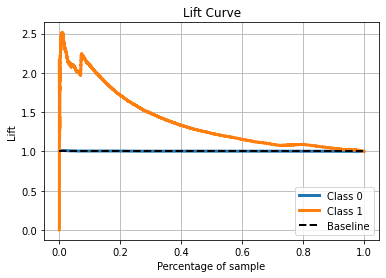

In [38]:
skplt.metrics.plot_lift_curve(df_new_jan[['RC_FLAG']], new_jan_prob_result)
plt.show()

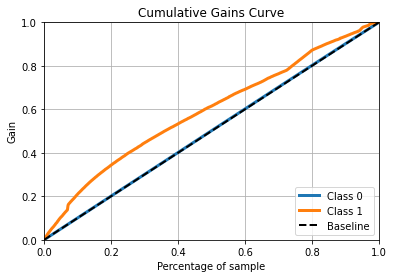

In [39]:
skplt.metrics.plot_cumulative_gain(df_new_jan[['RC_FLAG']], new_jan_prob_result)
plt.show()

# Save mar to gbq

## Existing

In [40]:
%%bigquery df_mar
SELECT
    MOBILE
    ,TARGET_MONTH
    ,TPV_6M
    ,TS
    ,COVER_DAY_6M
    ,PT_FIX_SPEED_UL_COVER_6M
    ,TOTAL_MONTH
    ,SOF_OTHER_FREQ_6M
    ,PT_FIX_SPEED_NS_COVER_6M
    ,V_CODE_6M
    ,RC_FLAG
    ,RC_RECENCY
    ,SIM_MONTH_AGE
FROM `acm-bi.Analysis.SA_VAS_RECURRING_202006_202103_FACT`
WHERE RC_RECENCY <> -1
AND TARGET_MONTH = '2021-03-01'

In [41]:
mar_prob_result = model.predict_proba(df_mar.drop(['MOBILE','TARGET_MONTH','RC_FLAG','RC_RECENCY'],axis=1))
df_mar['PROB'] = mar_prob_result[:,1:]

In [42]:
df_mar.columns

Index(['MOBILE', 'TARGET_MONTH', 'TPV_6M', 'TS', 'COVER_DAY_6M',
       'PT_FIX_SPEED_UL_COVER_6M', 'TOTAL_MONTH', 'SOF_OTHER_FREQ_6M',
       'PT_FIX_SPEED_NS_COVER_6M', 'V_CODE_6M', 'RC_FLAG', 'RC_RECENCY',
       'SIM_MONTH_AGE', 'PROB'],
      dtype='object')

In [43]:
df_mar.to_gbq(
    destination_table='Analysis.SA_VAS_RECURRING_EXISTING_MAR21_RESULT',
    project_id='acm-bi',
    if_exists='replace',
    table_schema=table_schema
)

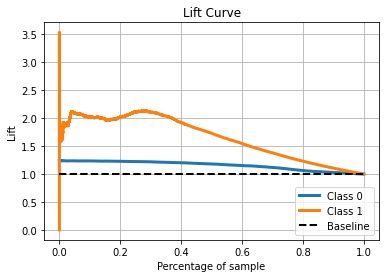

In [44]:
skplt.metrics.plot_lift_curve(df_mar[['RC_FLAG']], mar_prob_result)
plt.show()

## New RC

In [45]:
%%bigquery df_new_mar
SELECT
    MOBILE
    ,TARGET_MONTH
    ,TPV_6M
    ,TS
    ,COVER_DAY_6M
    ,PT_FIX_SPEED_UL_COVER_6M
    ,TOTAL_MONTH
    ,SOF_OTHER_FREQ_6M
    ,PT_FIX_SPEED_NS_COVER_6M
    ,V_CODE_6M
    ,RC_FLAG
    ,RC_RECENCY
    ,SIM_MONTH_AGE
FROM `acm-bi.Analysis.SA_VAS_RECURRING_202006_202103_FACT`
WHERE RC_RECENCY = -1
AND TARGET_MONTH = '2021-03-01'

In [46]:
new_mar_prob_result = model.predict_proba(df_new_mar.drop(['MOBILE','TARGET_MONTH','RC_FLAG','RC_RECENCY'],axis=1))
df_new_mar['PROB'] = new_mar_prob_result[:,1:]

In [47]:
df_new_mar.to_gbq(
    destination_table='Analysis.SA_VAS_RECURRING_NEW_MAR21_RESULT',
    project_id='acm-bi',
    if_exists='replace',
    table_schema=table_schema
)

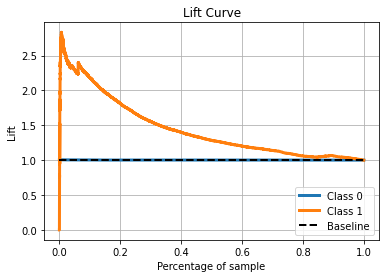

In [48]:
skplt.metrics.plot_lift_curve(df_new_mar[['RC_FLAG']], new_mar_prob_result)
plt.show()

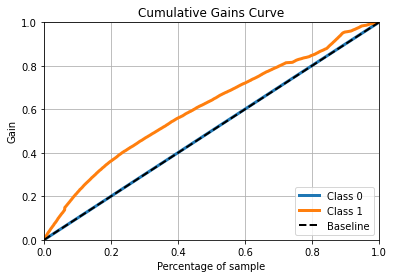

In [49]:
skplt.metrics.plot_cumulative_gain(df_new_mar[['RC_FLAG']], new_mar_prob_result)
plt.show()